# __Neural Network__ (keras; fasion_mnist)

В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде __класифікувати__ товари із датасету `fasion_mnist`.

Вам належить запропонувати свою власну архітектуру мережі. Точність найнаївнішої, але адекватної нейромережі становить приблизно __91%__. Точність вашої моделі повинна бути `не нижчою` за цей показник. Щоб досягти таких значень вам знадобиться `поекспериментувати з гіперпараметрами мережі`:

- кількість шарів;

- кількість нейронів;

- функції активації;

- кількість епох;

- розмір батчу;

- вибір оптимізатора;

- різні техніки регуляризації і т.д.

Використайте вивчені `техніки виявлення проблем навчання` нейронної мережі, і потім `поекспериментуйте`.

Рішення оформіть у вигляді окремого ноутбука.

In [93]:
from collections import Counter
import itertools
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.activations import mish, relu, sigmoid, softmax
from tensorflow.keras.datasets import fashion_mnist
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras import losses
from keras import metrics
from keras import optimizers


In [94]:
def set_seed(seed_value: int) -> None:
    """Set a random state for repeatability of results."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = 'true'
    

set_seed(1)

In [95]:
# hyperparameters+
cfg = {
       'learning_rate': 0.001,
       # 'training_steps': 3000,
       'batch_size': 256, # для перерахунку ваг не на всій вибірці
       # 'display_step': 100,
       'n_hidden_1': 256,
       'n_hidden_2': 64,
       # 'buffer_size': 5000,
       'epochs_limit': 100,
       }

### __`OBTAIN` & `SCRUB`__ + __`EXPLORE`__ (DATASET)

In [96]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train.dtype, x_train[0].shape

(dtype('uint8'), (28, 28))

In [97]:
cfg['num_features'] = x_train[0].shape[0] * x_train[0].shape[1]
cfg.get('num_features')

784

In [98]:
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# each sample (28x28) to 1x784
x_train, x_test = x_train.reshape([-1, cfg.get('num_features')]), x_test.reshape([-1, cfg.get('num_features')])
print(min(x_train.min(), x_test.min()))
maximum = max(x_train.max(), x_test.max()) # np.max([x_train.max(), x_test.max()]) 
maximum

0.0


255.0

In [99]:
# Normalize (min = 0)
x_train, x_test = x_train / maximum, x_test / maximum

In [100]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [101]:
cfg['num_classes'] = len(set(np.concatenate((y_train, y_test), axis=0)))

In [102]:
# num_classes = Counter(y_train)
# cfg['num_classes'] = len(num_classes)
# num_classes

In [103]:
y_true = tf.one_hot(y_train, depth=cfg.get('num_classes')).numpy()
y_truev = tf.one_hot(y_test, depth=cfg.get('num_classes')).numpy()
y_true.shape, y_truev.shape

((60000, 10), (10000, 10))

In [104]:
cfg

{'learning_rate': 0.001,
 'batch_size': 256,
 'n_hidden_1': 256,
 'n_hidden_2': 64,
 'epochs_limit': 100,
 'num_features': 784,
 'num_classes': 10}

### __`MODEL`__

- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
- https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy

In [105]:
n_hidden_ = [cfg.get('num_features'), 256, 64, cfg.get('num_classes')]
act='relu'
optimizators = [optimizers.legacy.SGD, optimizers.legacy.RMSprop, optimizers.legacy.Adam]  # 3
learning_rates = [10**el for el in range(-4, -1)]  # 3
n_epoch = 100  # max limit
batch_sizes = [2**el for el in range(7, 10)]  # 3
learning_rates, batch_sizes

([0.0001, 0.001, 0.01], [128, 256, 512])

In [106]:
def create_NN(name: str, n_hidden_: list, activation: str, optimizer=optimizers.SGD, learning_rate=0.1) -> Sequential:
    model = Sequential(name=name)
    model.add(Dense(n_hidden_[1], activation=activation, input_shape=(n_hidden_[0],)))
    model.add(Dense(n_hidden_[2], activation=activation))
    model.add(Dense(n_hidden_[3], activation='softmax'))
    model.compile(
                  optimizer=optimizer(learning_rate=learning_rate),  # legacy
                  loss=losses.CategoricalCrossentropy(),  # 'categorical_crossentropy' losses.binary_crossentropy,
                  metrics=['accuracy', metrics.CategoricalAccuracy()]  # metrics.BinaryAccuracy()  CategoricalAccuracy()
                  )

    return model

In [107]:
models = []  # 
for opt in optimizators:  # 3
    for lr in learning_rates:  # 3
        for bs in batch_sizes:  # 3
            models.append(create_NN(
                                    name=f'nn-{n_hidden_[1]}-{n_hidden_[2]}-{act}-{opt.__name__}-lr{lr}-bs{bs}', 
                                    n_hidden_=n_hidden_, 
                                    activation=act, 
                                    optimizer=opt, 
                                    learning_rate=lr
                                    )
                          )

In [108]:
models[3].summary()

Model: "nn-256-64-relu-SGD-lr0.001-bs128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4003 (Dense)          (None, 256)               200960    
                                                                 
 dense_4004 (Dense)          (None, 64)                16448     
                                                                 
 dense_4005 (Dense)          (None, 10)                650       
                                                                 
Total params: 218058 (851.79 KB)
Trainable params: 218058 (851.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [109]:
len(models), models[26].name

(27, 'nn-256-64-relu-Adam-lr0.01-bs512')

#### __`Training`__

In [110]:
history = {}  # 9 * 3 = 27
for num, model in enumerate(models):
    history[model.name] = model.fit(
                                    x_train,
                                    y_true,
                                    epochs=cfg.get('epochs_limit'),
                                    batch_size=bs,
                                    validation_data=(x_test, y_truev)
                                    )

Epoch 1/100
118/118 [==============================] - 1s 8ms/step - loss: 2.4527 - accuracy: 0.0889 - categorical_accuracy: 0.0889 - val_loss: 2.4181 - val_accuracy: 0.0864 - val_categorical_accuracy: 0.0864
Epoch 2/100
118/118 [==============================] - 1s 7ms/step - loss: 2.3944 - accuracy: 0.0839 - categorical_accuracy: 0.0839 - val_loss: 2.3655 - val_accuracy: 0.0820 - val_categorical_accuracy: 0.0820
Epoch 3/100
118/118 [==============================] - 1s 7ms/step - loss: 2.3459 - accuracy: 0.0808 - categorical_accuracy: 0.0808 - val_loss: 2.3207 - val_accuracy: 0.0826 - val_categorical_accuracy: 0.0826
Epoch 4/100
118/118 [==============================] - 1s 7ms/step - loss: 2.3035 - accuracy: 0.0831 - categorical_accuracy: 0.0831 - val_loss: 2.2807 - val_accuracy: 0.0873 - val_categorical_accuracy: 0.0873
Epoch 5/100
118/118 [==============================] - 1s 6ms/step - loss: 2.2652 - accuracy: 0.0947 - categorical_accuracy: 0.0947 - val_loss: 2.2442 - val_accurac

### __`INTERPRET`__ / __`Error Analysis`__

In [111]:
def draw_2twin_2d(y00: np.array, y01: np.array, y10: np.array, y11: np.array, suptitle: str) -> None:
    x = range(1, len(y00) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))

    axs[0].plot(x, y00, 'bo', label='Training loss')
    axs[0].plot(x, y01, 'g', label='Validation loss')
    axs[0].title.set_text('Training and validation loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(x, y10, 'bo', label='Training acc')
    axs[1].plot(x, y11, 'g', label='Validation acc')
    axs[1].title.set_text('Training and validation acc')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Acc')
    axs[1].legend()
    axs[1].grid()
    
    fig.suptitle(suptitle)
    # plt.legend()
    # plt.grid()
    axs[1].grid()
    plt.show()

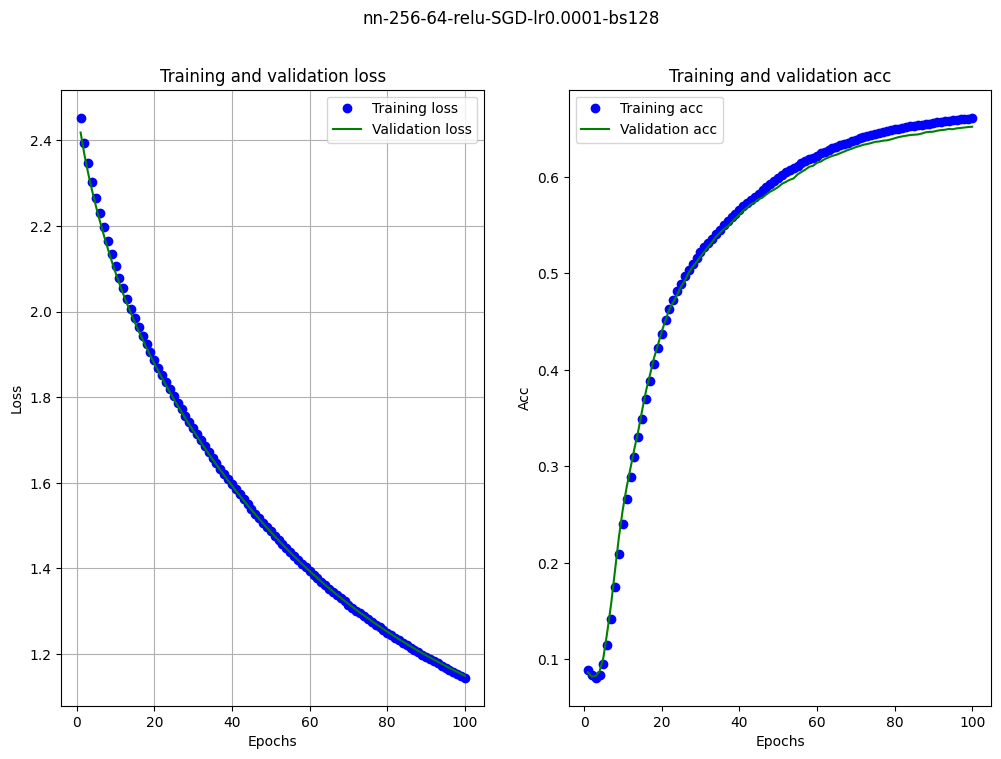

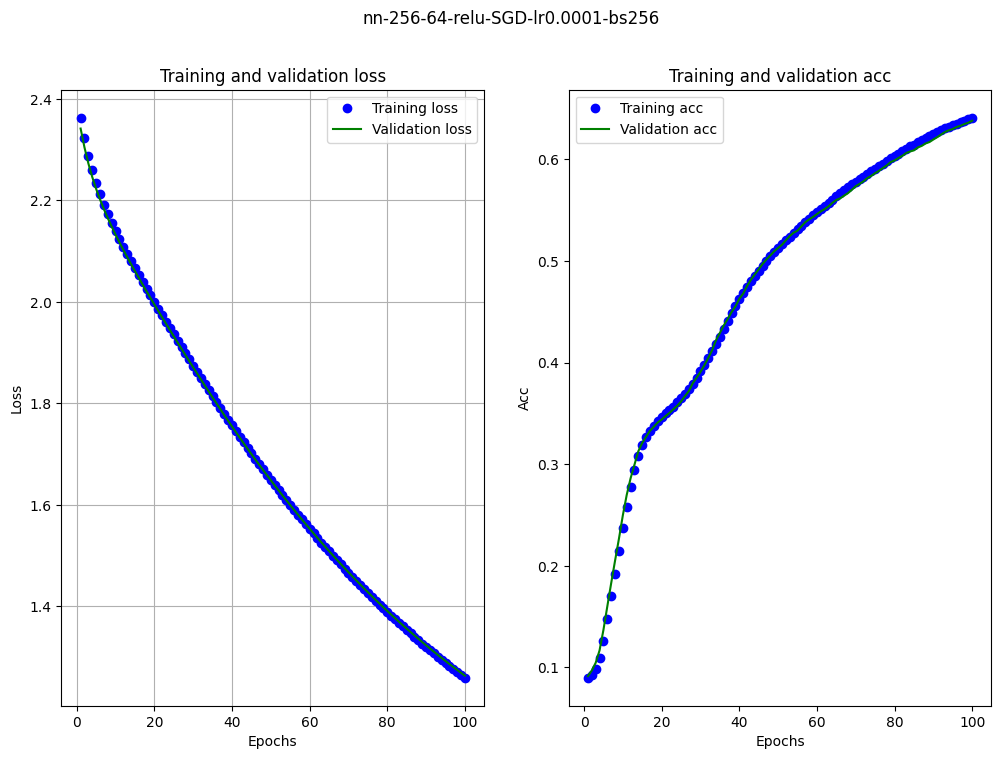

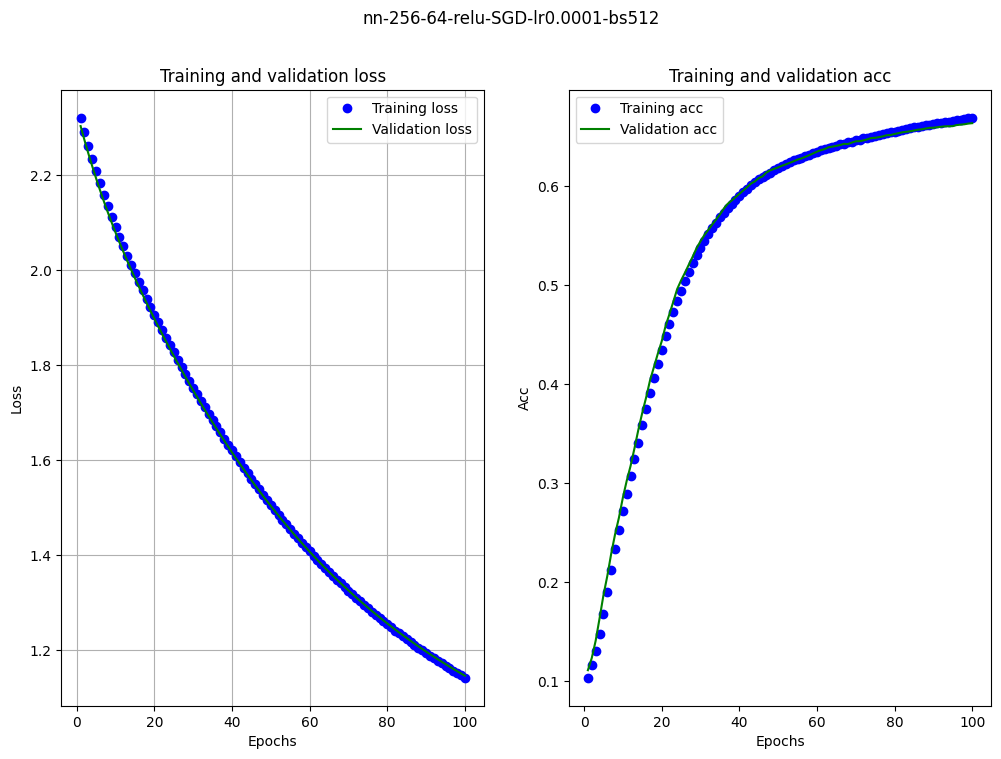

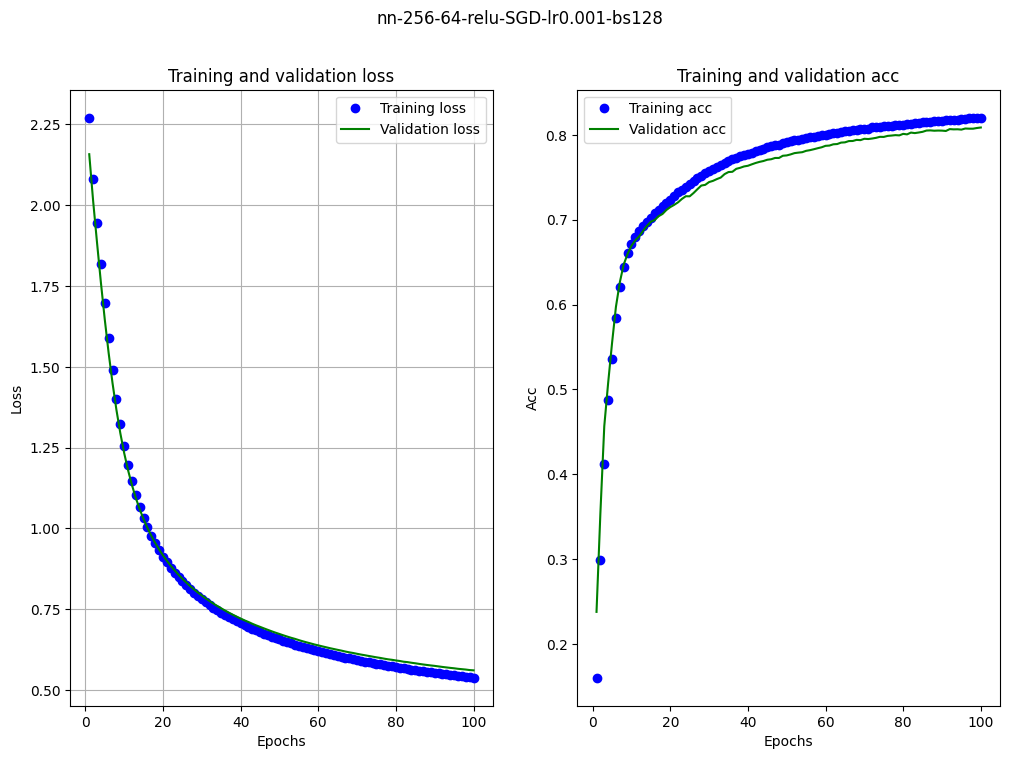

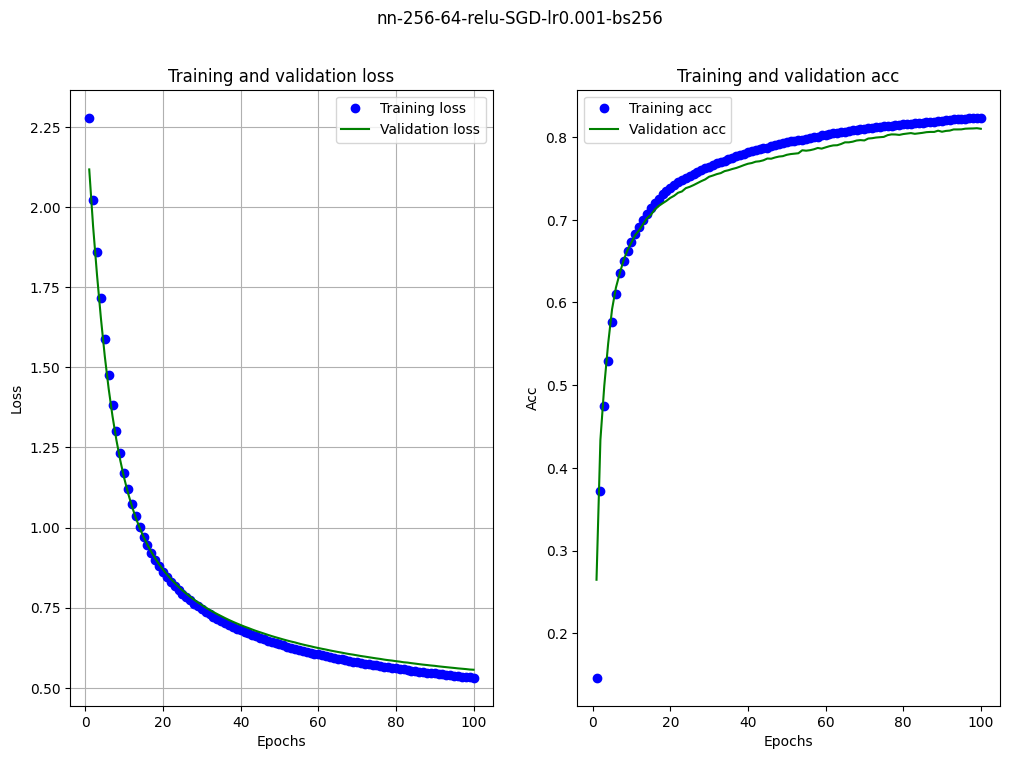

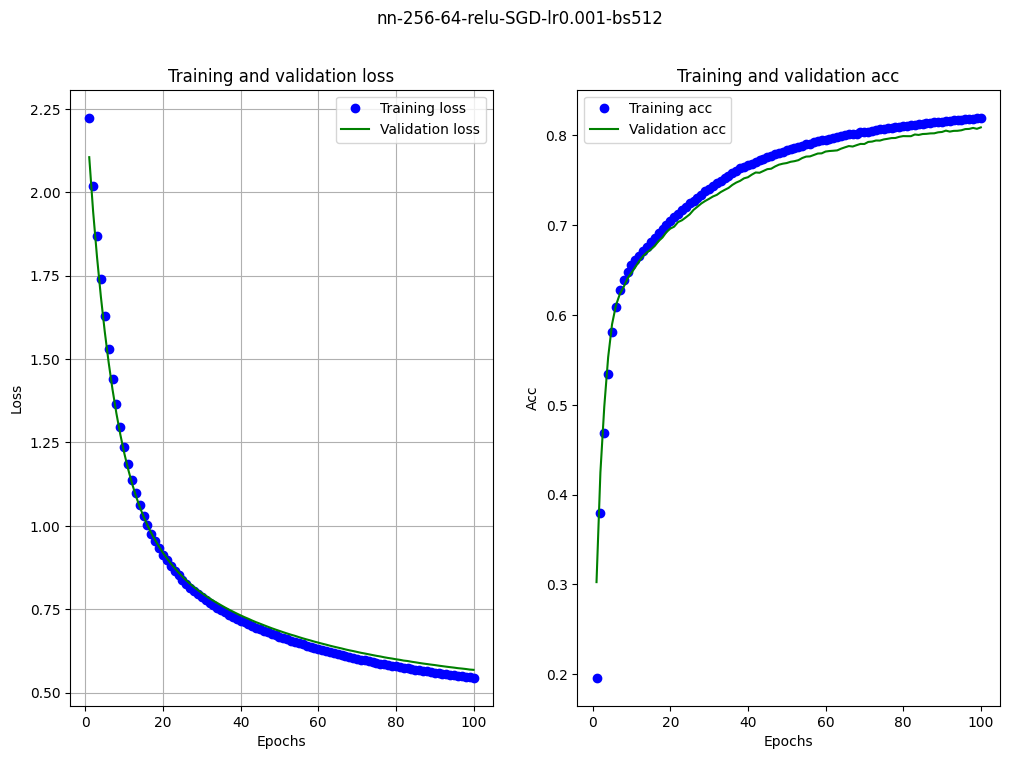

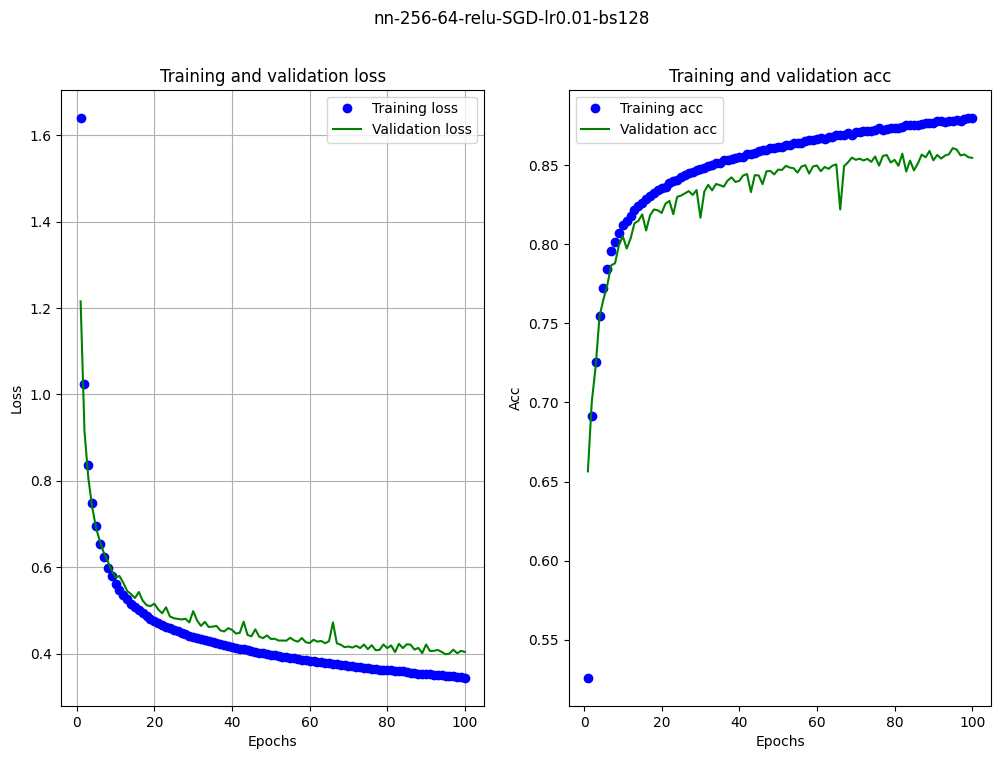

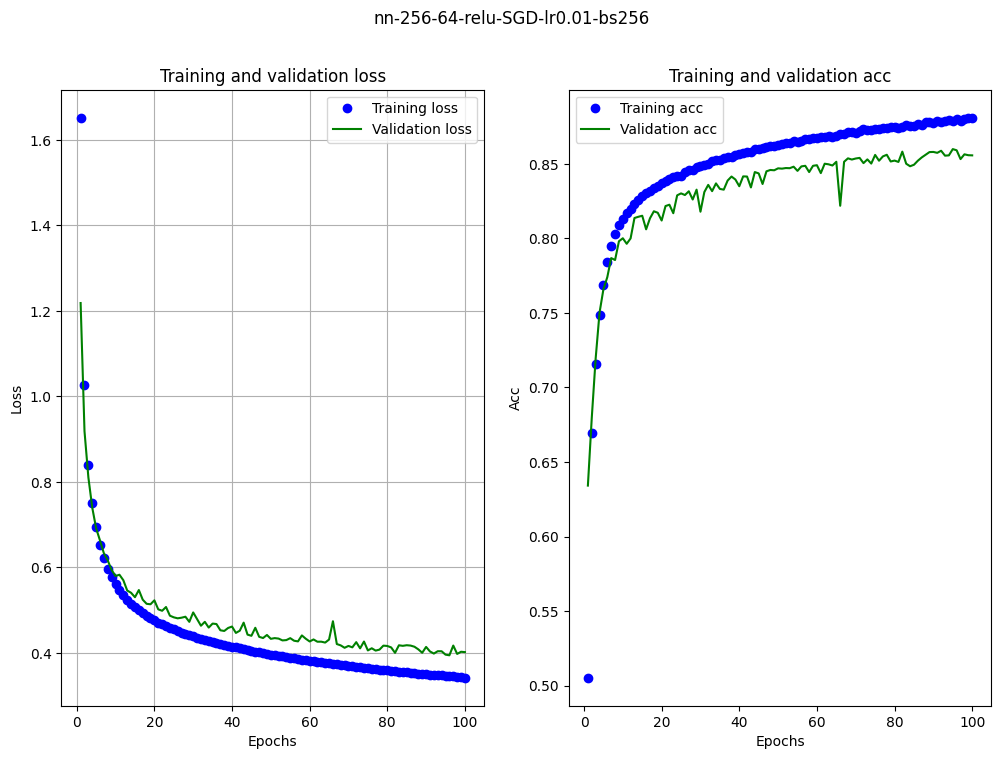

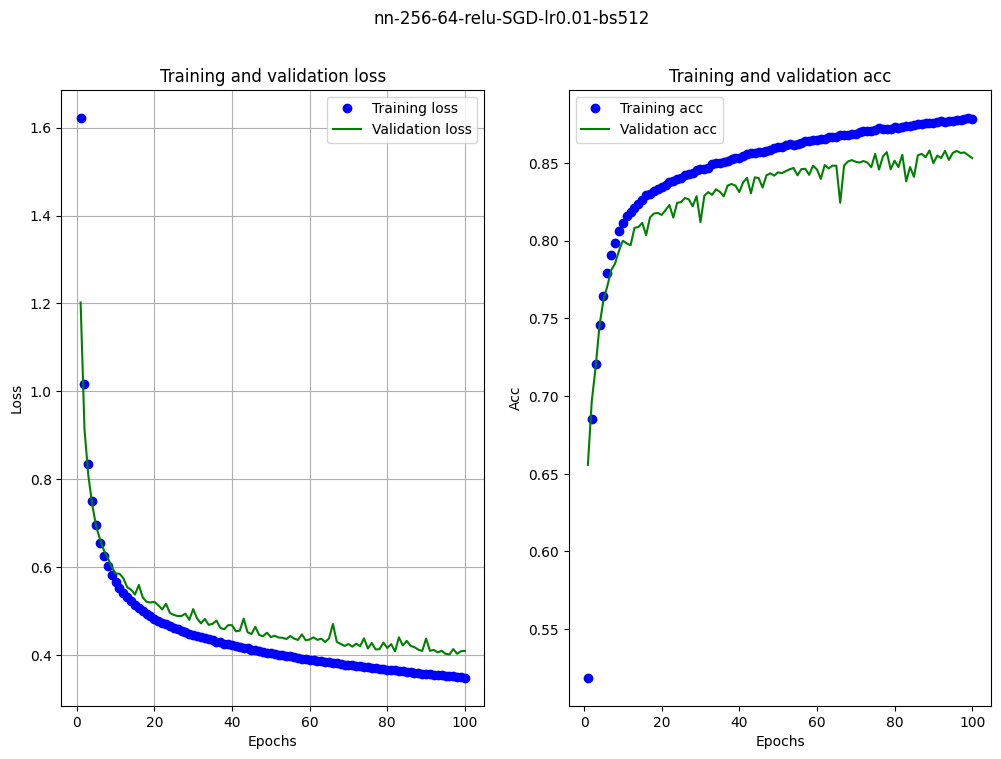

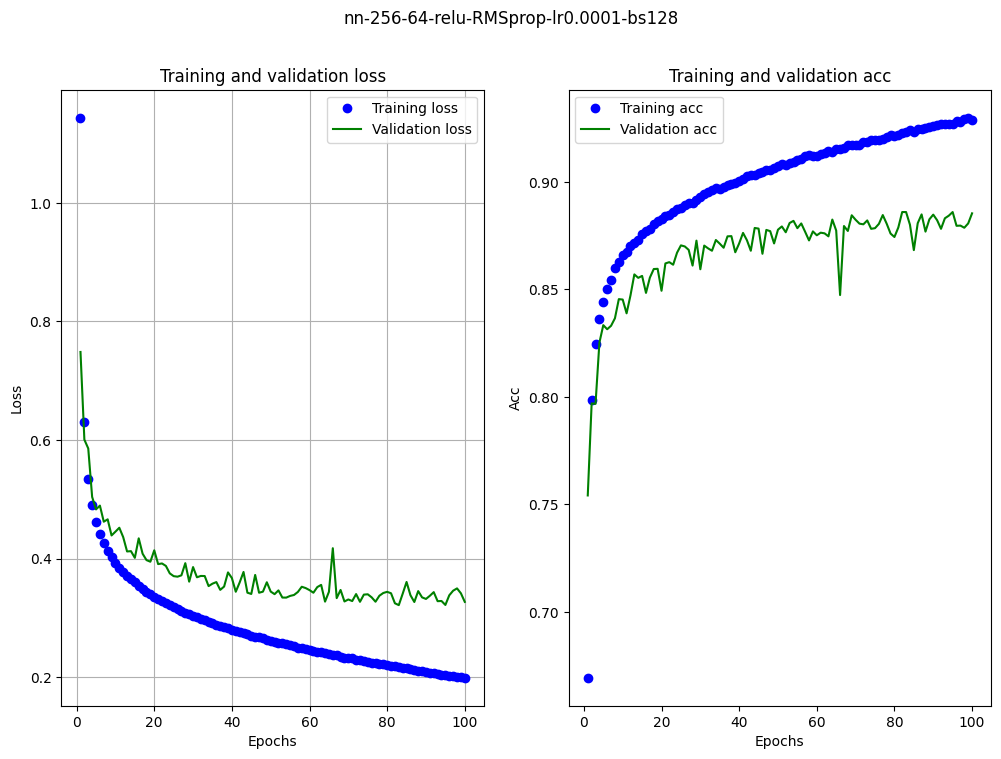

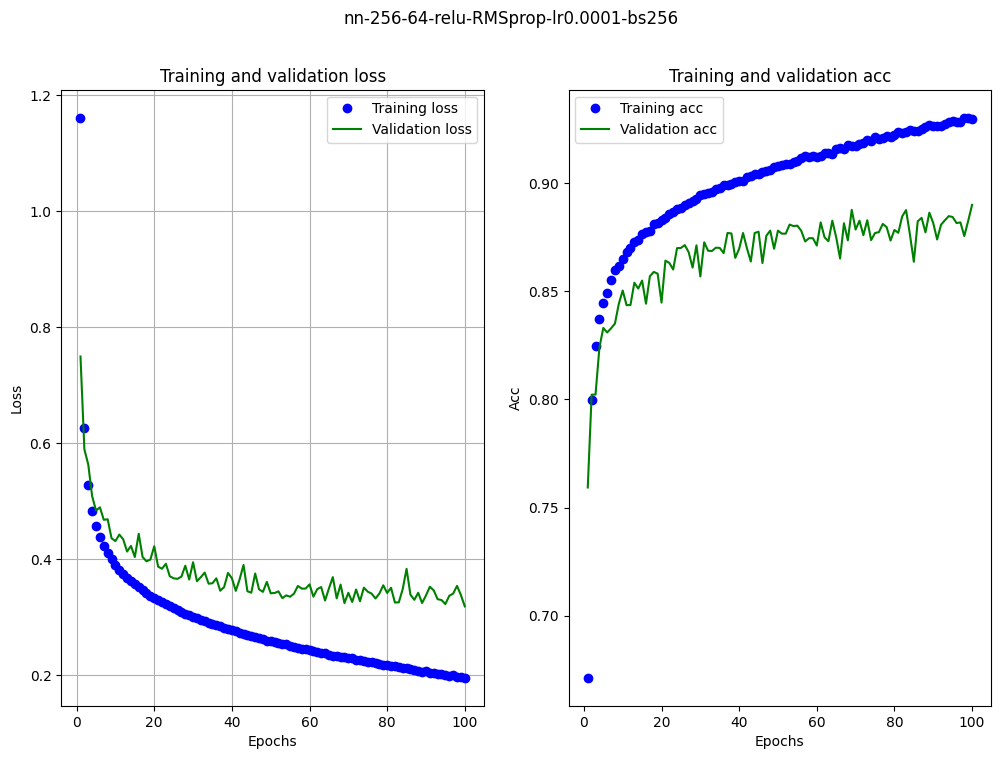

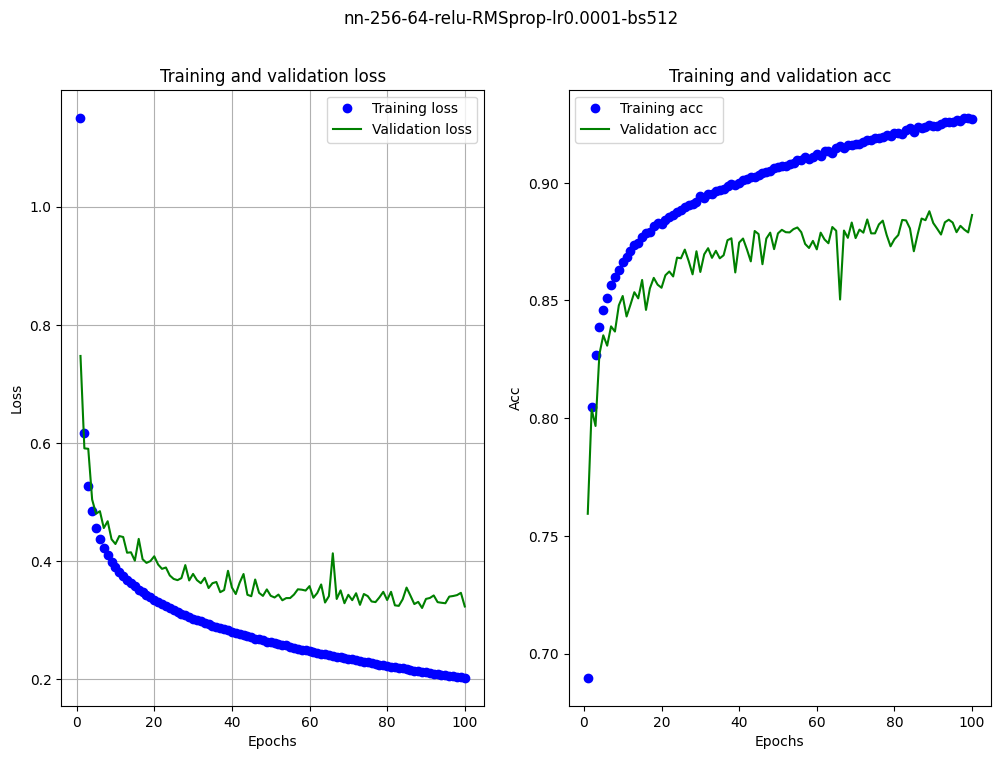

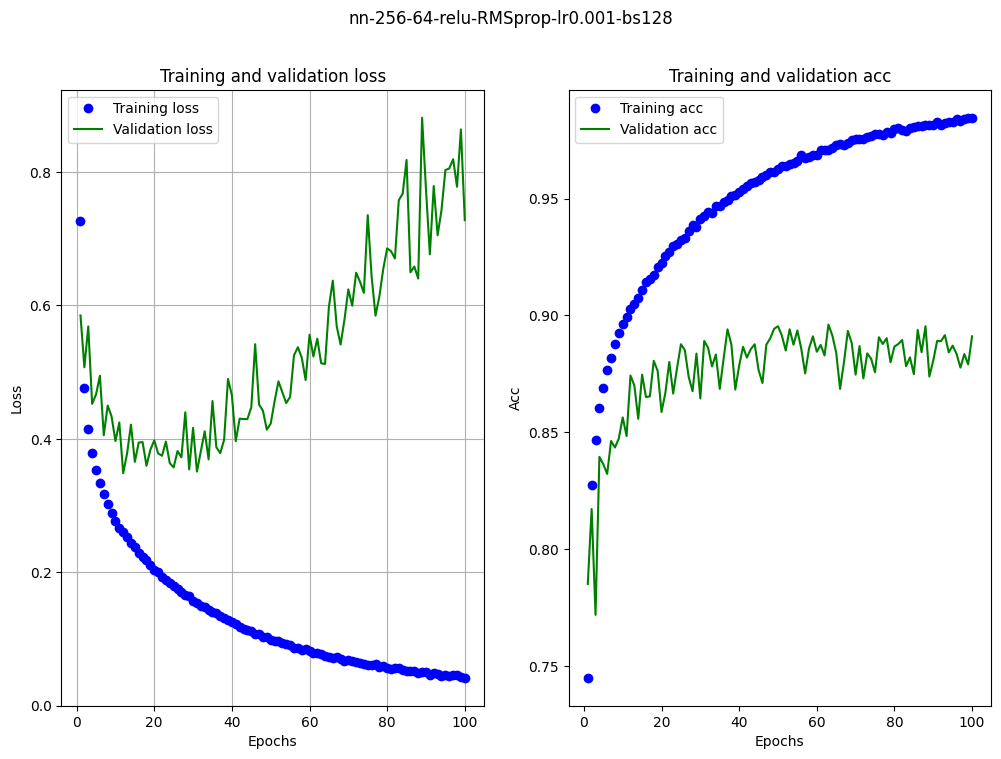

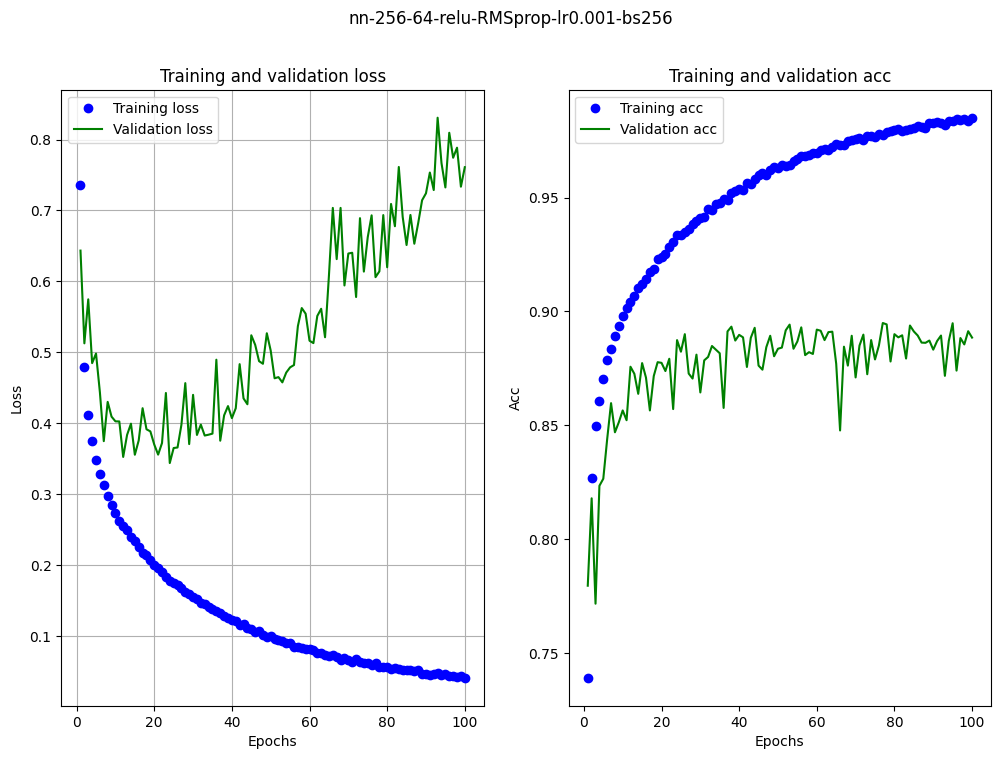

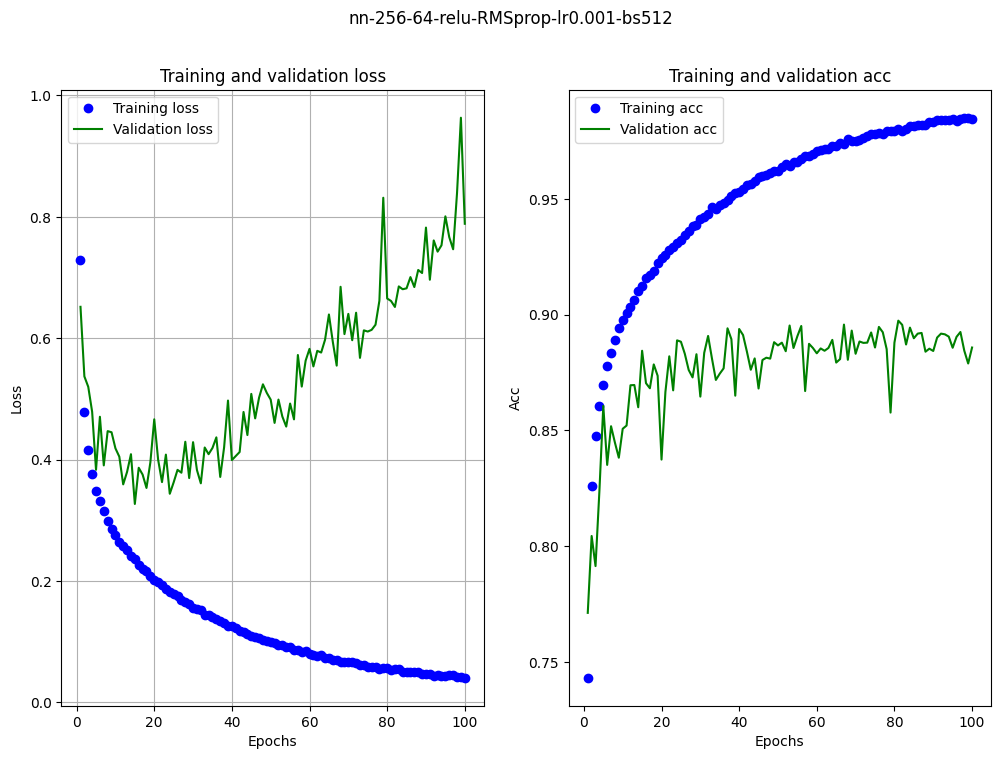

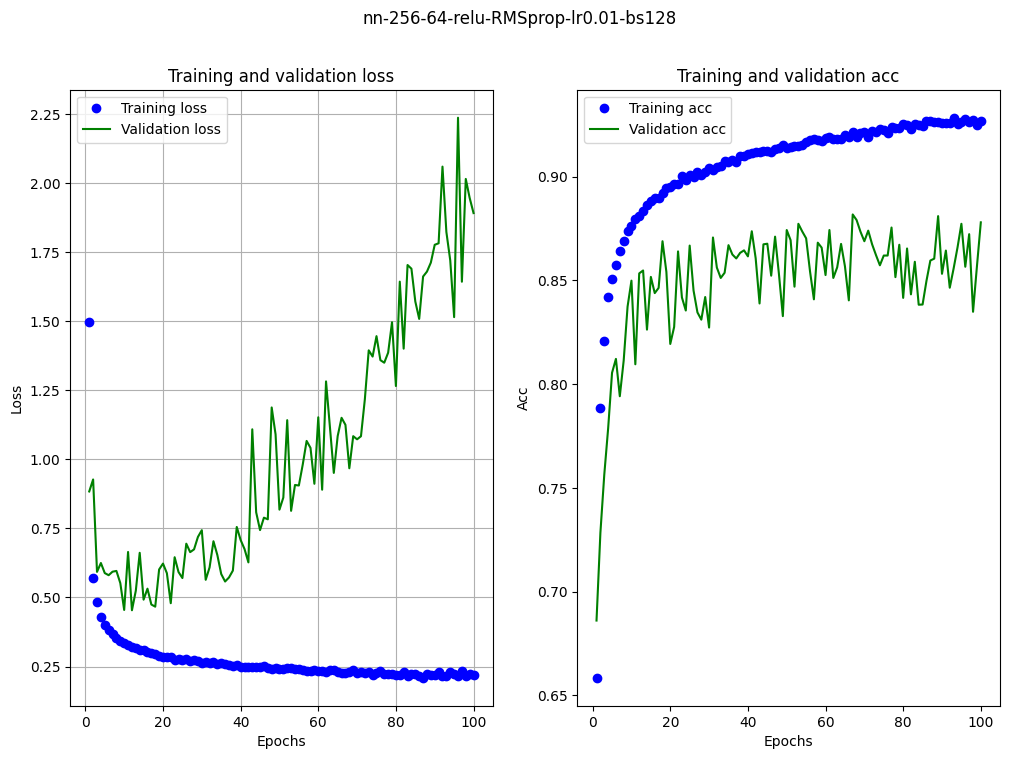

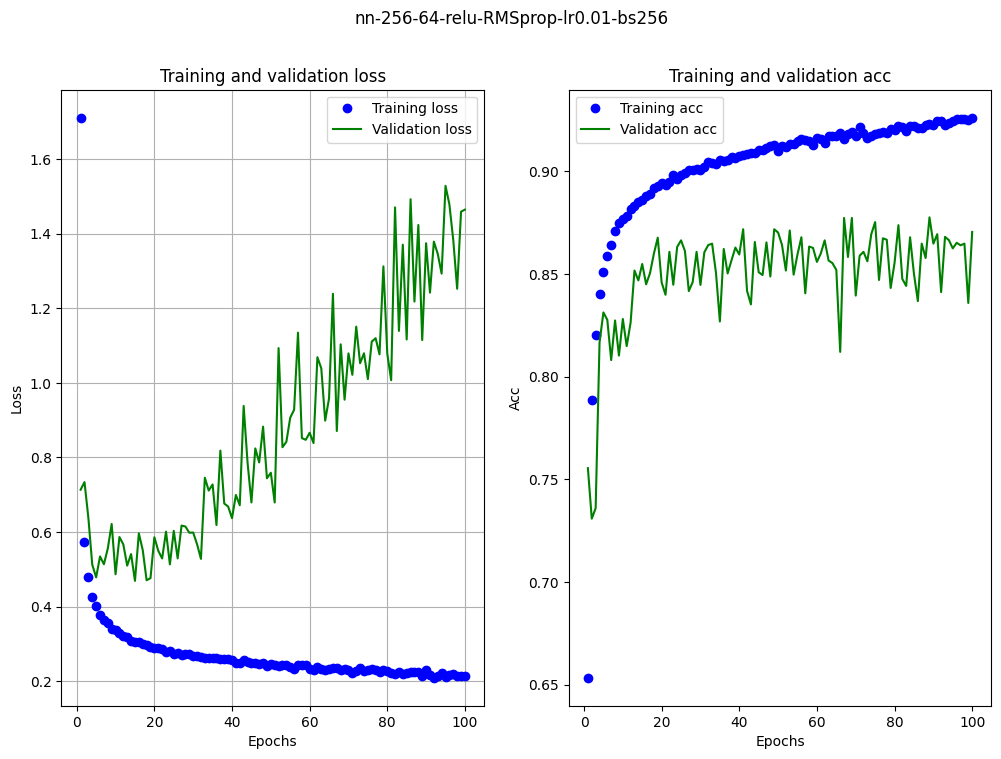

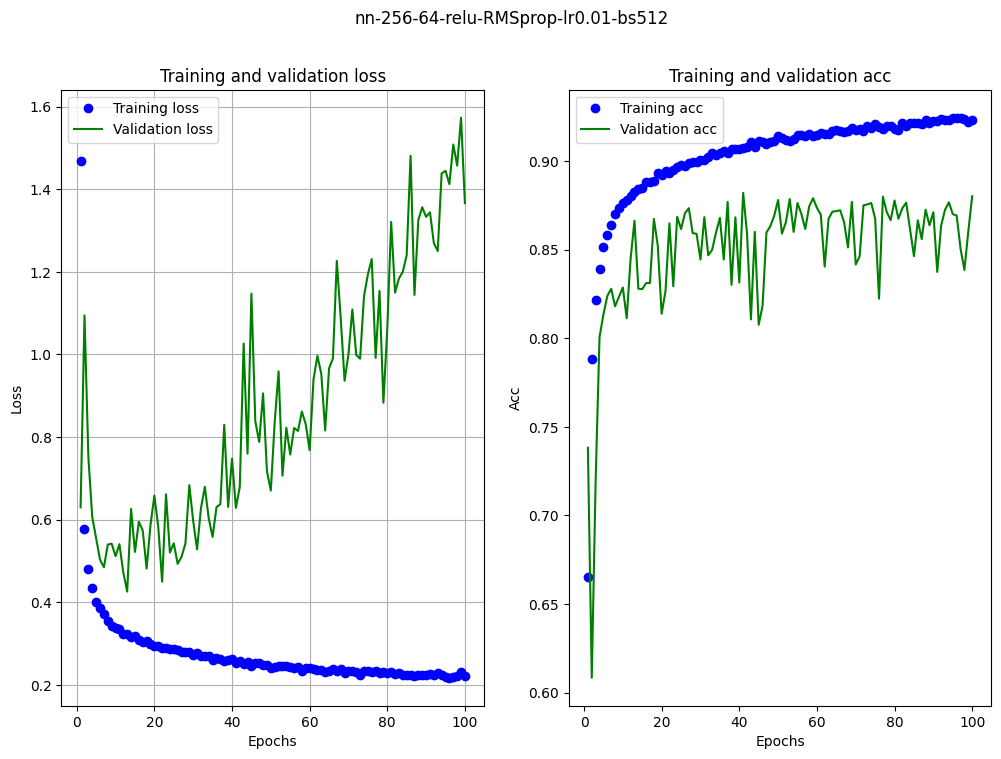

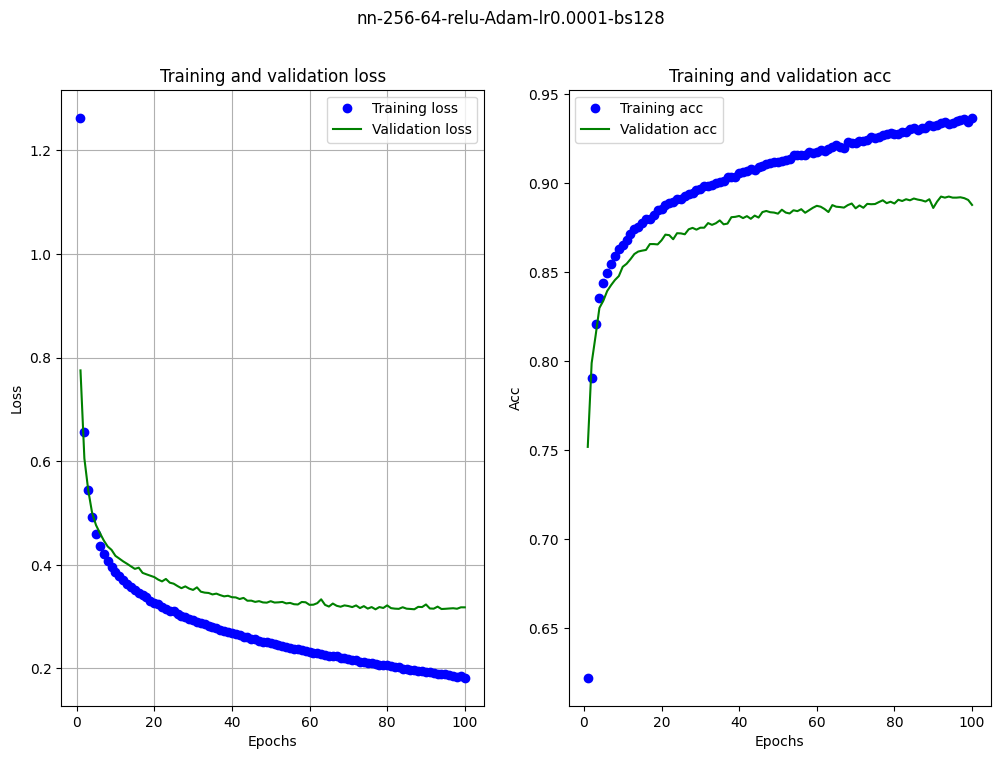

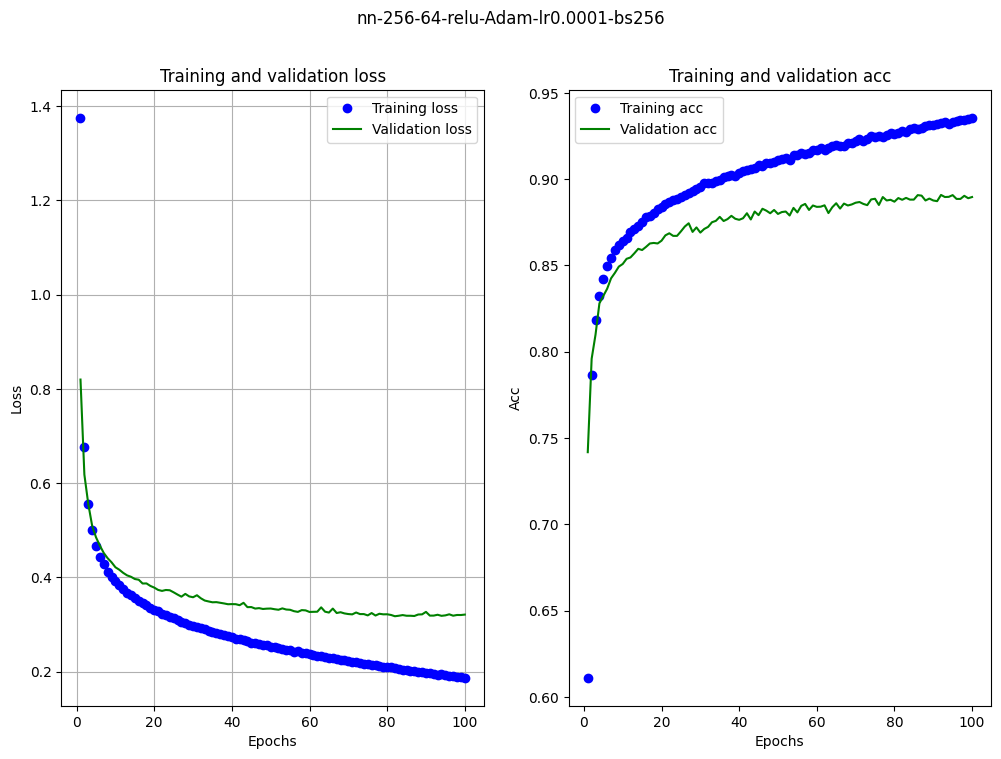

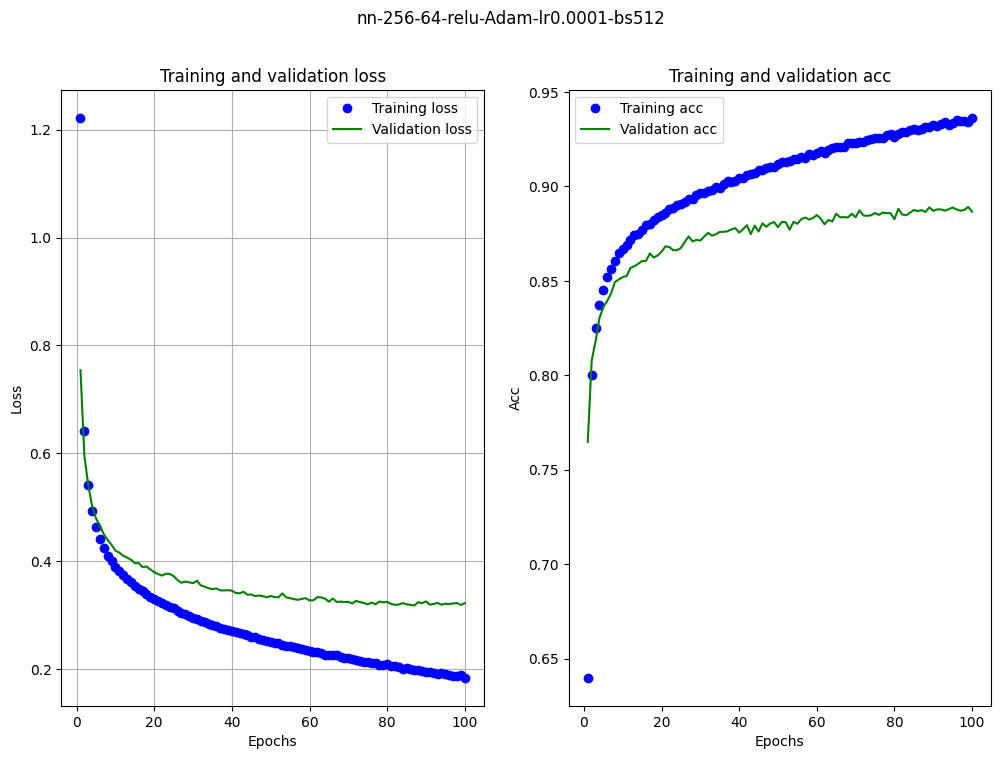

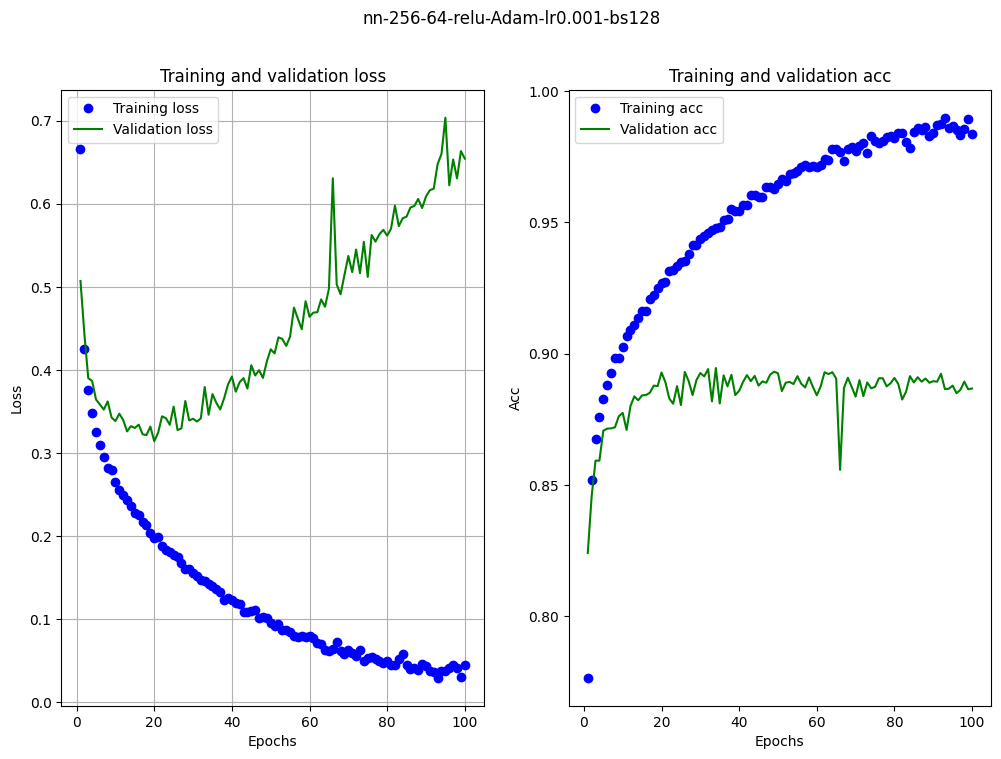

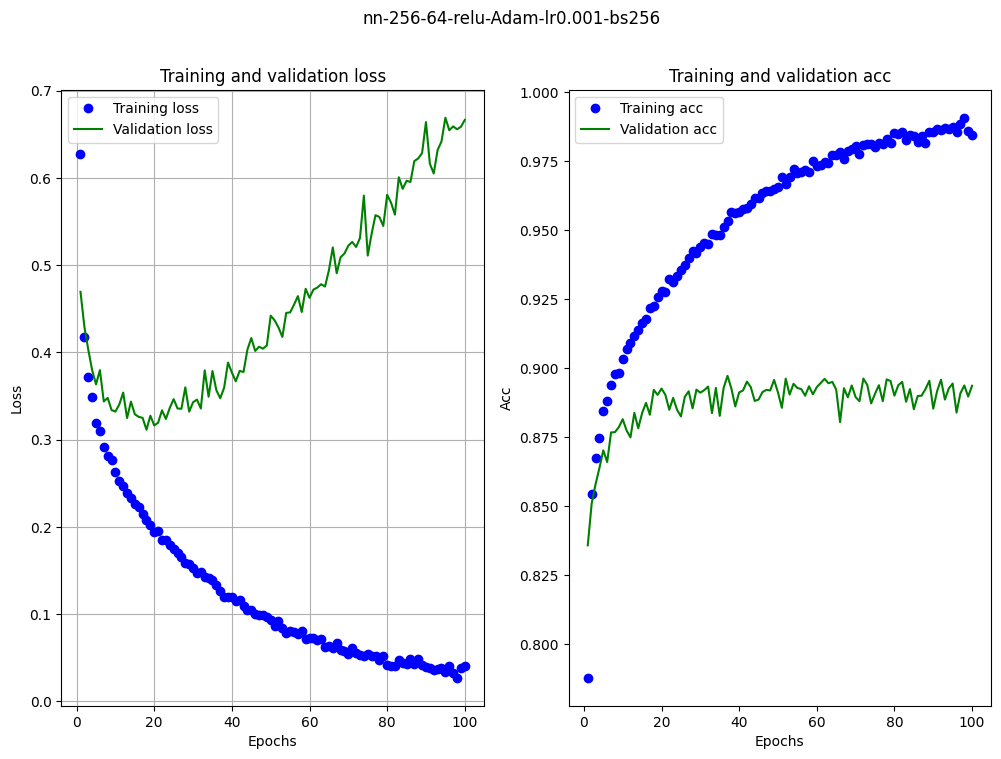

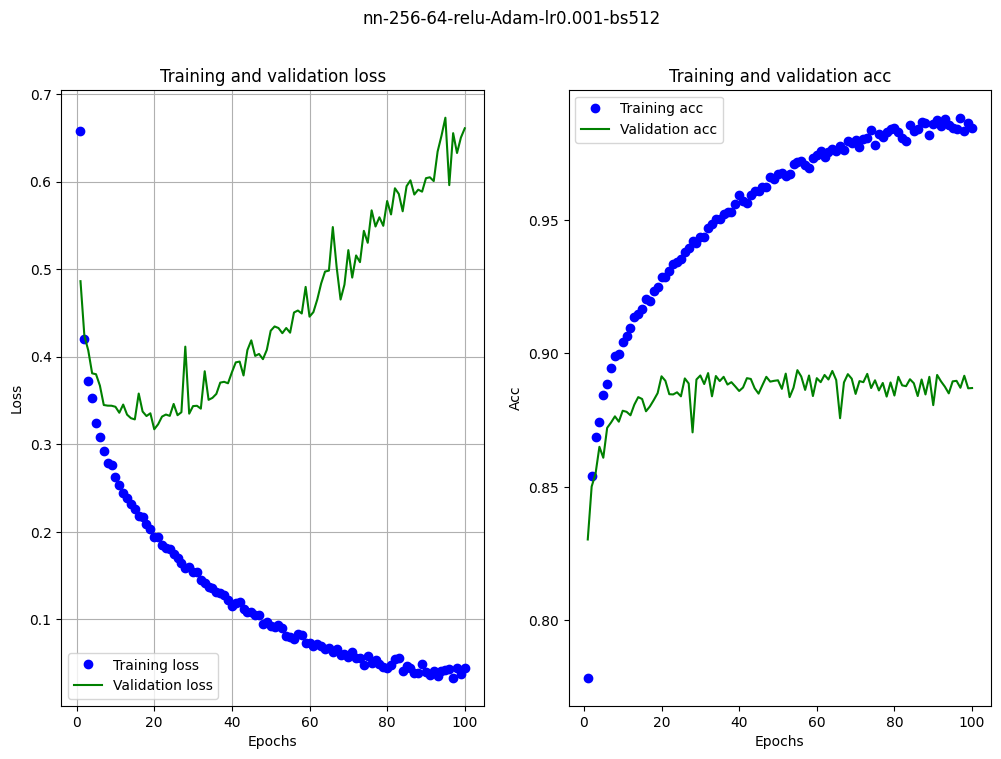

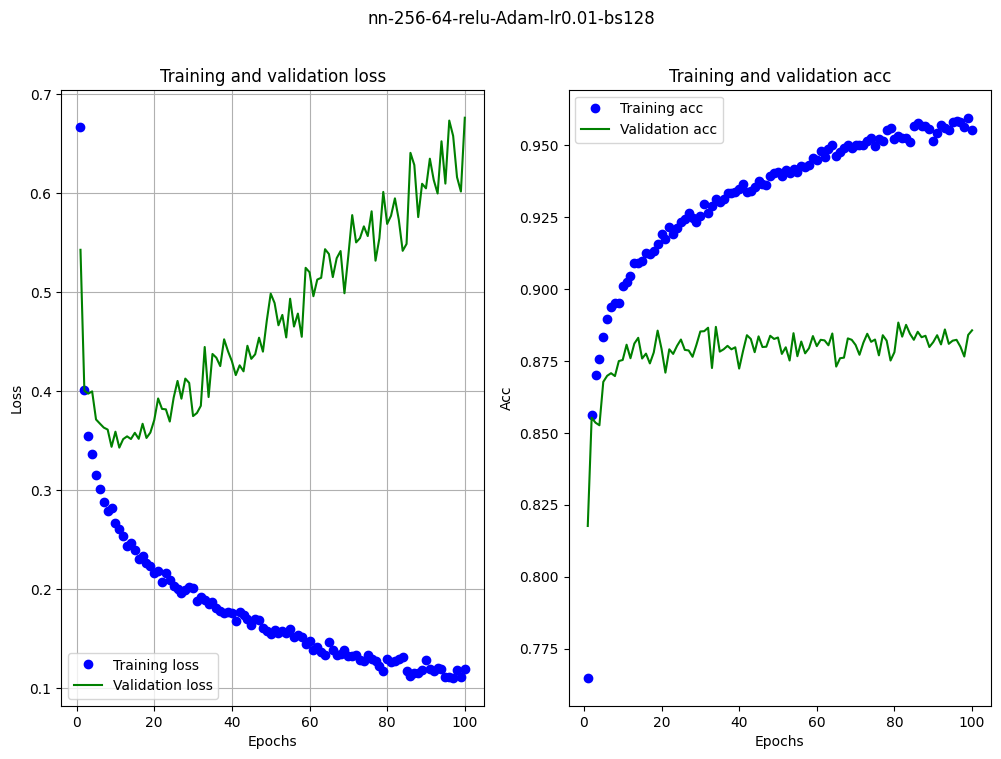

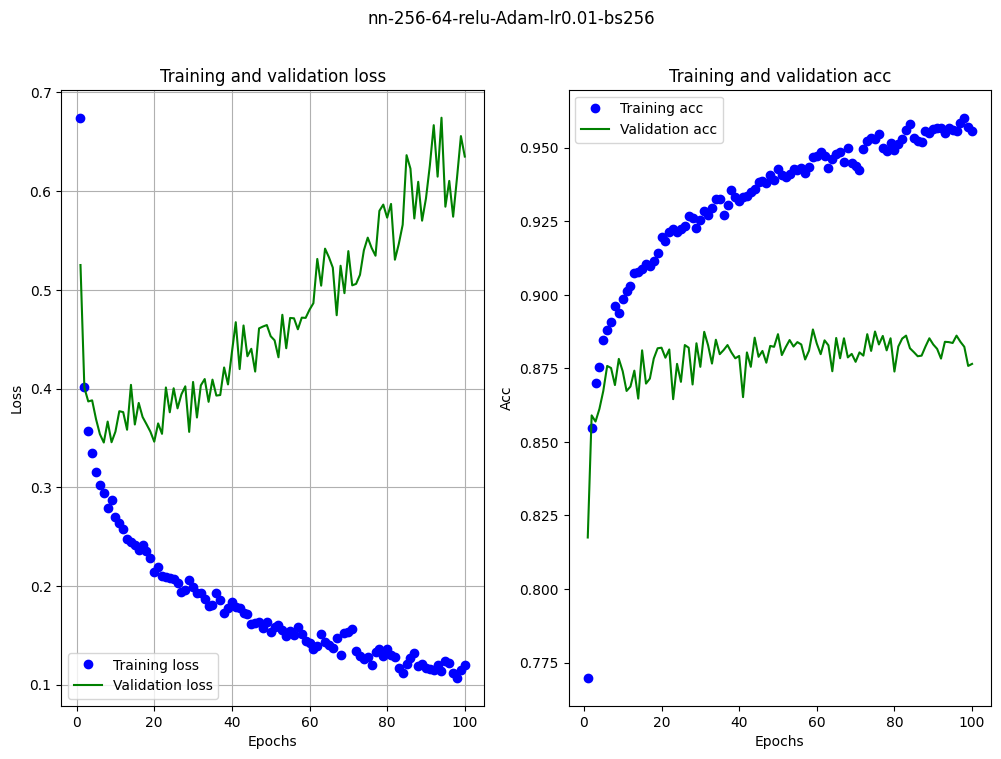

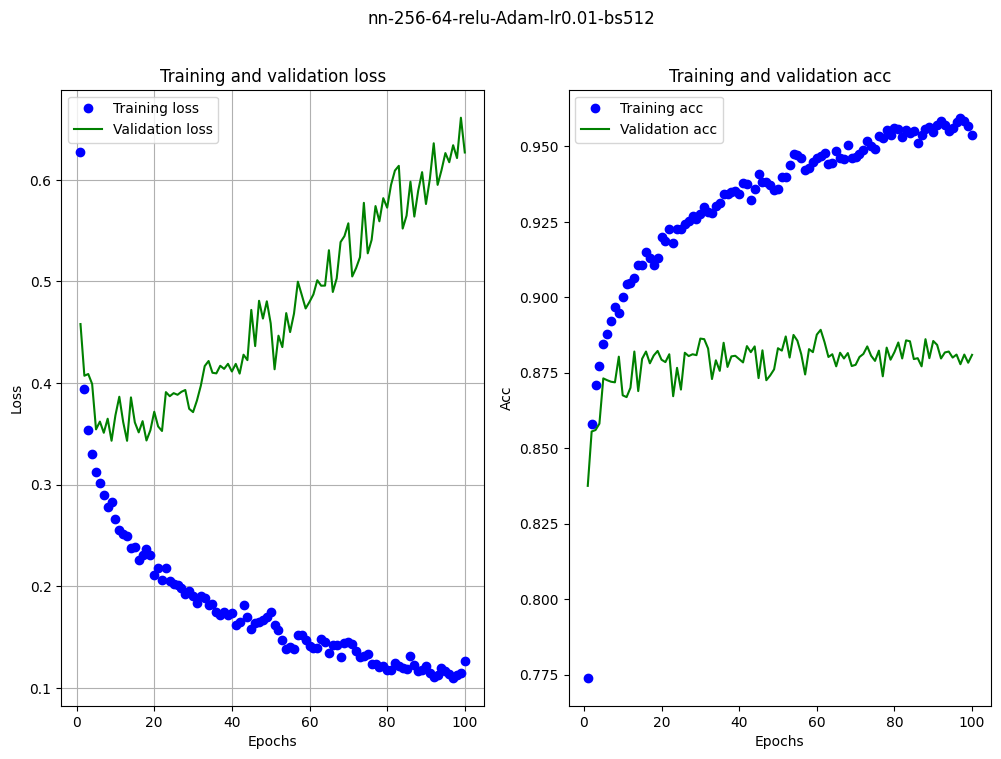

In [112]:
for model in history:
    history_dict = history[model].history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']   

    draw_2twin_2d(loss_values, val_loss_values, acc_values, val_acc_values, suptitle=model)

### __`RE-TEST`__

In [145]:
n_hidden_2 = [cfg.get('num_features'), 4096, 1024, cfg.get('num_classes')]
act='relu'
optimizators = [optimizers.legacy.Adam]  # 1
learning_rates = [(10**el)/4 for el in range(-3, -2)]  # 1
batch_sizes = [1024]  # 2
learning_rates, batch_sizes

([0.00025], [1024])

In [146]:
models2 = []  # 
for opt in optimizators:  # 1
    for lr in learning_rates:  # 2
        for bs in batch_sizes:  # 2
            models2.append(create_NN(
                                    name=f'nn-{n_hidden_2[1]}-{n_hidden_2[2]}-{act}-{opt.__name__}-lr{lr}-bs{bs}', 
                                    n_hidden_=n_hidden_2, 
                                    activation=act, 
                                    optimizer=opt, 
                                    learning_rate=lr
                                    )
                          )

In [147]:
history2 = {}  # 9 * 3 = 27
for num, model in enumerate(models2):
    history2[model.name] = model.fit(
                                     x_train,
                                     y_true,
                                     epochs=cfg.get('epochs_limit'),
                                     batch_size=bs,
                                     validation_data=(x_test, y_truev)
                                     )

Epoch 1/100
59/59 [==============================] - 10s 173ms/step - loss: 0.6207 - accuracy: 0.7869 - categorical_accuracy: 0.7869 - val_loss: 0.4578 - val_accuracy: 0.8379 - val_categorical_accuracy: 0.8379
Epoch 2/100
59/59 [==============================] - 10s 165ms/step - loss: 0.3982 - accuracy: 0.8595 - categorical_accuracy: 0.8595 - val_loss: 0.4108 - val_accuracy: 0.8550 - val_categorical_accuracy: 0.8550
Epoch 3/100
59/59 [==============================] - 10s 164ms/step - loss: 0.3506 - accuracy: 0.8760 - categorical_accuracy: 0.8760 - val_loss: 0.3819 - val_accuracy: 0.8625 - val_categorical_accuracy: 0.8625
Epoch 4/100
59/59 [==============================] - 10s 170ms/step - loss: 0.3134 - accuracy: 0.8878 - categorical_accuracy: 0.8878 - val_loss: 0.3804 - val_accuracy: 0.8630 - val_categorical_accuracy: 0.8630
Epoch 5/100
59/59 [==============================] - 10s 164ms/step - loss: 0.2970 - accuracy: 0.8935 - categorical_accuracy: 0.8935 - val_loss: 0.3418 - val_ac

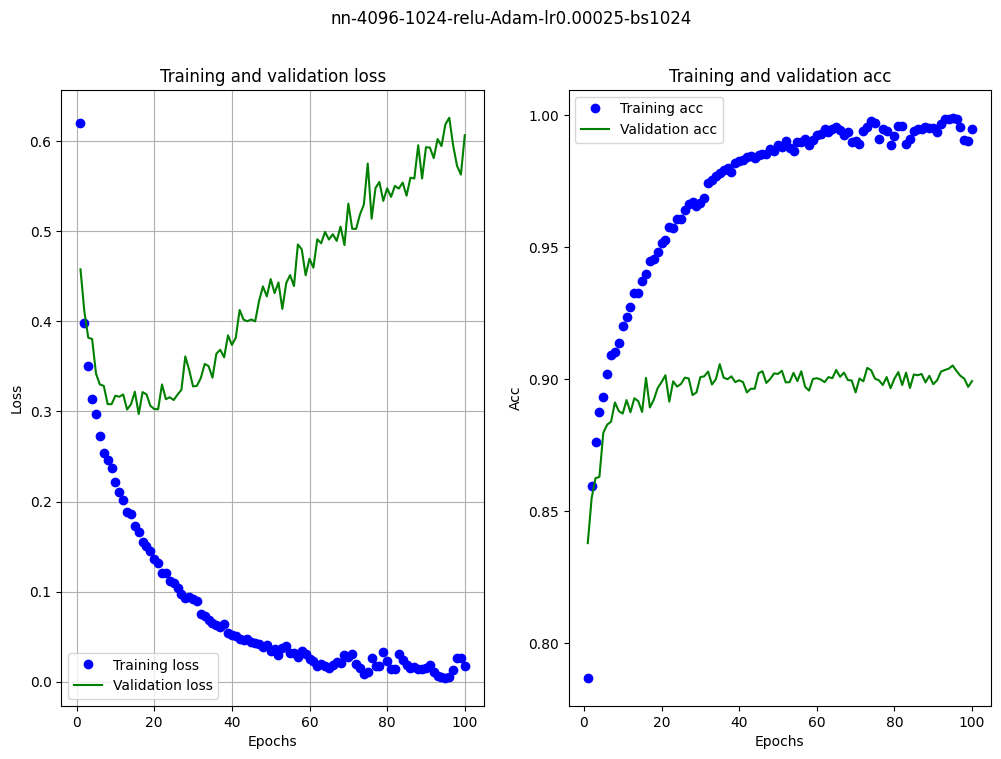

In [148]:
for model in history2:
    history_dict = history2[model].history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']   

    draw_2twin_2d(loss_values, val_loss_values, acc_values, val_acc_values, suptitle=model)

Epoch 1/40
59/59 [==============================] - 106s 2s/step - loss: 0.6094 - accuracy: 0.7915 - categorical_accuracy: 0.7915 - val_loss: 0.4110 - val_accuracy: 0.8550 - val_categorical_accuracy: 0.8550
Epoch 2/40
59/59 [==============================] - 105s 2s/step - loss: 0.3553 - accuracy: 0.8710 - categorical_accuracy: 0.8710 - val_loss: 0.3779 - val_accuracy: 0.8637 - val_categorical_accuracy: 0.8637
Epoch 3/40
59/59 [==============================] - 105s 2s/step - loss: 0.3106 - accuracy: 0.8855 - categorical_accuracy: 0.8855 - val_loss: 0.3410 - val_accuracy: 0.8781 - val_categorical_accuracy: 0.8781
Epoch 4/40
59/59 [==============================] - 105s 2s/step - loss: 0.2788 - accuracy: 0.8968 - categorical_accuracy: 0.8968 - val_loss: 0.3410 - val_accuracy: 0.8781 - val_categorical_accuracy: 0.8781
Epoch 5/40
59/59 [==============================] - 105s 2s/step - loss: 0.2584 - accuracy: 0.9050 - categorical_accuracy: 0.9050 - val_loss: 0.3229 - val_accuracy: 0.8853 

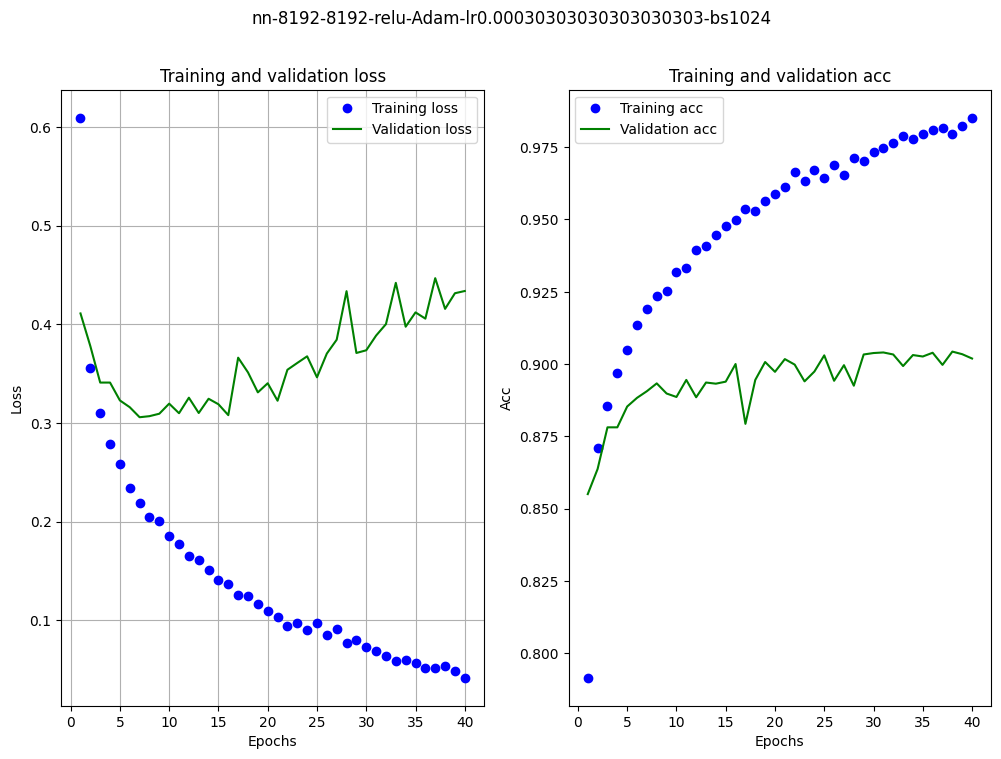

In [151]:
cfg['epochs_limit'] = 40
n_hidden_2 = [cfg.get('num_features'), 8192, 8192, cfg.get('num_classes')]
act='relu'
optimizators = [optimizers.legacy.Adam]  # 1
learning_rates = [(10**el)/3.3 for el in range(-3, -2)]  # 1
batch_sizes = [1024]  # 2
learning_rates, batch_sizes

models2 = []  # 
for opt in optimizators:  # 1
    for lr in learning_rates:  # 2
        for bs in batch_sizes:  # 2
            models2.append(create_NN(
                                    name=f'nn-{n_hidden_2[1]}-{n_hidden_2[2]}-{act}-{opt.__name__}-lr{lr}-bs{bs}', 
                                    n_hidden_=n_hidden_2, 
                                    activation=act, 
                                    optimizer=opt, 
                                    learning_rate=lr
                                    )
                          )
            
history2 = {}  # 9 * 3 = 27
for num, model in enumerate(models2):
    history2[model.name] = model.fit(
                                     x_train,
                                     y_true,
                                     epochs=cfg.get('epochs_limit'),
                                     batch_size=bs,
                                     validation_data=(x_test, y_truev)
                                     )
    
for model in history2:
    history_dict = history2[model].history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']   

    draw_2twin_2d(loss_values, val_loss_values, acc_values, val_acc_values, suptitle=model)

Epoch 1/100
59/59 [==============================] - 1s 9ms/step - loss: 1.1522 - accuracy: 0.6257 - categorical_accuracy: 0.6257 - val_loss: 0.6917 - val_accuracy: 0.7556 - val_categorical_accuracy: 0.7556
Epoch 2/100
59/59 [==============================] - 0s 7ms/step - loss: 0.5935 - accuracy: 0.7963 - categorical_accuracy: 0.7963 - val_loss: 0.5534 - val_accuracy: 0.8091 - val_categorical_accuracy: 0.8091
Epoch 3/100
59/59 [==============================] - 0s 7ms/step - loss: 0.4999 - accuracy: 0.8291 - categorical_accuracy: 0.8291 - val_loss: 0.5049 - val_accuracy: 0.8234 - val_categorical_accuracy: 0.8234
Epoch 4/100
59/59 [==============================] - 0s 7ms/step - loss: 0.4569 - accuracy: 0.8434 - categorical_accuracy: 0.8434 - val_loss: 0.4680 - val_accuracy: 0.8383 - val_categorical_accuracy: 0.8383
Epoch 5/100
59/59 [==============================] - 0s 7ms/step - loss: 0.4293 - accuracy: 0.8525 - categorical_accuracy: 0.8525 - val_loss: 0.4504 - val_accuracy: 0.8419 

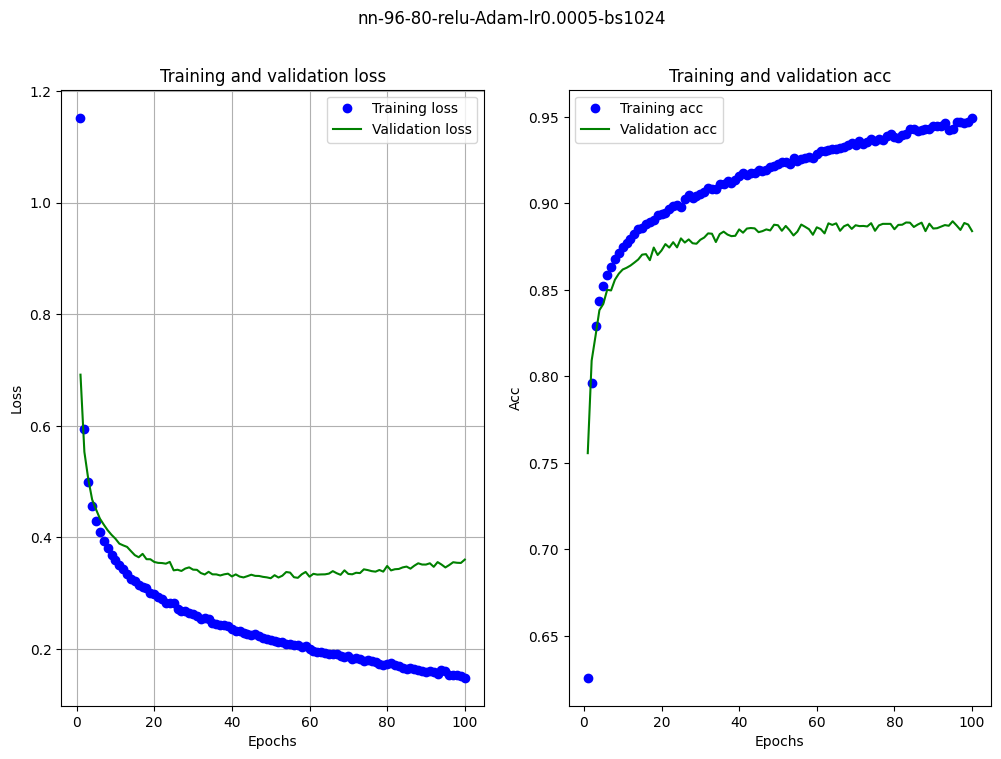

In [153]:
cfg['epochs_limit'] = 100
n_hidden_2 = [cfg.get('num_features'), 96, 80, cfg.get('num_classes')]
act='relu'
optimizators = [optimizers.legacy.Adam]  # 1
learning_rates = [(10**el)/2 for el in range(-3, -2)]  # 1
batch_sizes = [1024]  # 2
learning_rates, batch_sizes

models2 = []  # 
for opt in optimizators:  # 1
    for lr in learning_rates:  # 2
        for bs in batch_sizes:  # 2
            models2.append(create_NN(
                                    name=f'nn-{n_hidden_2[1]}-{n_hidden_2[2]}-{act}-{opt.__name__}-lr{lr}-bs{bs}', 
                                    n_hidden_=n_hidden_2, 
                                    activation=act, 
                                    optimizer=opt, 
                                    learning_rate=lr
                                    )
                          )
            
history2 = {}  # 9 * 3 = 27
for num, model in enumerate(models2):
    history2[model.name] = model.fit(
                                     x_train,
                                     y_true,
                                     epochs=cfg.get('epochs_limit'),
                                     batch_size=bs,
                                     validation_data=(x_test, y_truev)
                                     )
    
for model in history2:
    history_dict = history2[model].history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']   

    draw_2twin_2d(loss_values, val_loss_values, acc_values, val_acc_values, suptitle=model)

### __`RESULTS` & `CONCLUSIONS`__